# Introduction to digital signal processing

Install the requirements

In [2]:
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

## The (fast) Fourier transformation

Speech consists of sounds that can be described w.r.t.

- the frequencies of the different sounds,
- the amplitude (or magnitude) of the different sounds,
- how the sounds change over time.

In [6]:
x.shape

(32000,)

In [18]:
n

array([    0,     1,     2, ..., 31997, 31998, 31999])

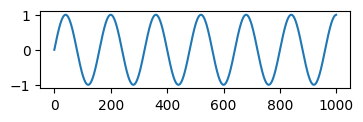

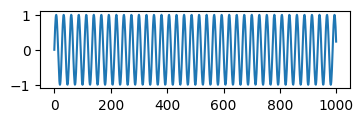

In [34]:
f_s=16000 # sampling rate
N = 2*f_s # number of samples for 2 seconds audio
n = np.arange(N) 
fq100 = 100 # frequency of the sine wave in Hz
fq600 = 600 # frequency of the sine wave in Hz
x100 = np.sin(2*np.pi*(fq100/f_s)*n) # generate sine wave
x600 = np.sin(2*np.pi*(fq600/f_s)*n) # generate sine wave

# visualise the sine wave
plt.figure(figsize=(4, 1))
plt.plot(n[:1000], x100[:1000])

plt.figure(figsize=(4, 1))
plt.plot(n[:1000], x600[:1000])

In [37]:
ipyd.Audio(rate=f_s, data=x100)

In [36]:
ipyd.Audio(rate=f_s, data=x600)

(0.0, 1000.0)

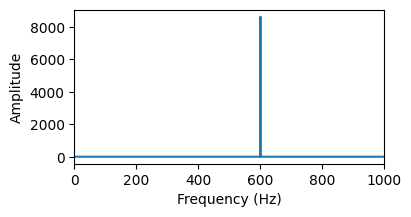

In [20]:
# Plot spectrum
N = len(x)
w = np.hamming(N)
X = np.fft.fft(x*w)
plt.figure(figsize=(4, 2))
plt.plot(np.linspace(0, f_s*(N - 1)/N, N), np.abs(X))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)